In [119]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm, ensemble
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')
import itertools
from nonconformist.icp import IcpClassifier
from nonconformist.nc import ClassifierNc, MarginErrFunc, ClassifierAdapter
import matplotlib.pyplot as plt
from folktables import ACSDataSource, ACSEmployment, ACSIncomePovertyRatio, ACSHealthInsurance

# Load Data

In [301]:
df = pd.read_csv("../data/acs_employment.csv")
df["race"] = (df["race"]==1).astype(int)

In [304]:
(df["race"]==1).sum()/len(df)

0.767758

In [305]:
(df["gender"]==1).sum()/len(df)

0.48947

In [121]:
protected_attributes = ["race", "gender"]
task_type = "employment"
n_train = int(0.6*len(df))
n_cal = int(0.2*len(df))
n_test = int(0.2*len(df))

In [122]:
def min_max_normalize(df):
    return (df-df.min())/(df.max()-df.min())

In [123]:
def format_data(task):
    df_train, df_test = sklearn.model_selection.train_test_split(df, test_size=0.2, random_state=0)
    df_train, df_cal = sklearn.model_selection.train_test_split(df_train, test_size=0.25, random_state=0)

    X_train = min_max_normalize(df_train.drop(columns=[task]+protected_attributes)).to_numpy()
    X_cal = min_max_normalize(df_cal.drop(columns=[task]+protected_attributes)).to_numpy()
    X_test = min_max_normalize(df_test.drop(columns=[task]+protected_attributes)).to_numpy()

    y_train, y_cal, y_test = df_train[task].to_numpy(), df_cal[task].to_numpy(), df_test[task].to_numpy()
    z_train, z_cal, z_test = df_train[protected_attributes].to_numpy(), df_cal[protected_attributes].to_numpy(), df_test[protected_attributes].to_numpy()

    return {'X_tr' : X_train, 'X_cal': X_cal, 'X_test' : X_test, 
            'y_tr': y_train, 'y_cal': y_cal, 'y_test' : y_test, 
            'z_tr': z_train, 'z_cal': z_cal, 'z_test': z_test}

In [124]:
data = format_data(task_type)

# Train Model

In [125]:
def accuracy_by_group(data, pred):
    df = pd.DataFrame(data["z_test"])
    df["pred"] = pred
    df["true"] = data["y_test"]
    
    acc = 100*(df["pred"]==df["true"]).sum()/len(df)
    print(acc)
    for i in range(data["z_test"].shape[1]):
        print(protected_attributes[i])
        for g in df[i].unique():
            curr = df[df[i]==g]
            acc = 100*(curr["pred"]==curr["true"]).sum()/len(curr)
            print(int(g), round(acc, 2))

In [128]:
base_clf = ensemble.GradientBoostingClassifier
base_clf = make_pipeline(base_clf(loss="exponential", n_estimators=5, max_depth=5, random_state=0))
model = CalibratedClassifierCV(base_clf)
model.fit(data['X_tr'], data['y_tr'])

CalibratedClassifierCV(estimator=Pipeline(steps=[('gradientboostingclassifier',
                                                  GradientBoostingClassifier(loss='exponential',
                                                                             max_depth=5,
                                                                             n_estimators=5,
                                                                             random_state=0))]))

In [129]:
pred_risk = model.predict_proba(data['X_test'])
pred_risk = [i[1] for i in pred_risk]

In [130]:
accuracy_by_group(data, np.round(pred_risk, 0))

80.945
race
1 81.31
0 79.76
gender
1 82.63
0 79.34


# Conformal Prediction

### 1 -- Nonconformity scores 
How much prediction differs from true class

In [133]:
def nonconformity_score(pred, y):
    return 1 - pred[y]

### 2 -- Nonconformity of calibration data
Nonconformity from true class

In [138]:
pred_cal = model.predict_proba(data['X_cal'])
nc_cal = []
for i in range(n_cal):
    nc_cal.append(nonconformity_score(pred_cal[i], data['y_cal'][i]))
nc_cal = np.array(nc_cal)

### 3 -- Nonconformity of test data
Nonconformity from each class

In [139]:
pred_test = model.predict_proba(data['X_test'])

nc_test = []
for i in range(n_test):
    nc_test.append([nonconformity_score(pred_test[i], 0),
                    nonconformity_score(pred_test[i], 1)])

### 4 -- PValues for test data

Assuming the true class, what is the probability of observing a more extreme nonconformity score?

In [140]:
def pvalue(s, scores=nc_cal):
    return (scores>s).sum() / len(scores)

In [141]:
pvalues = []
for nc in nc_test:
    pvalues.append(np.array([pvalue(nc[0]), pvalue(nc[1])]))
pvalues = np.array(pvalues)

### 5 -- Uncertainty Measures

- Credibility: how likely the sample is to come from the training set (minimum significance level such that conformal set is empty)
- Confidence: how certain the model is that the prediction is a singleton

In [142]:
cred = pvalues.max(axis=1)
conf = 1-pvalues.min(axis=1)

### Compare with library output
Note: Library applies stochastic smoothing of p-values

In [143]:
icp = IcpClassifier(ClassifierNc(ClassifierAdapter(model), MarginErrFunc()))
icp.calibrate(data["X_cal"], data["y_cal"])
pvalues_library = icp.predict(data["X_test"], None)
conf_library = icp.predict_conf(data["X_test"])

In [144]:
d = []
for i in range(n_test):
    for j in range(2):
        d.append(np.abs(pvalues_library[i][j] - pvalues[i][j]))
print("Average p-value disagreement", np.mean(np.array(d)))

Average p-value disagreement 0.053847385124096384


In [145]:
d = []
for i in range(n_test):
    d.append(np.abs(conf_library[i][1] - conf[i]))
print("Average conf disagreement", np.mean(np.array(d)))

Average conf disagreement 0.01901181851686997


In [146]:
d = []
for i in range(n_test):
    d.append(np.abs(conf_library[i][2] - cred[i]))
print("Average cred disagreement", np.mean(np.array(d)))

Average cred disagreement 0.08845812364768907


In [165]:
pvalues = pvalues_library
cred = conf_library[:, 2]
conf = conf_library[:, 1]

# Analysis

### Plot Nonconformity Scores

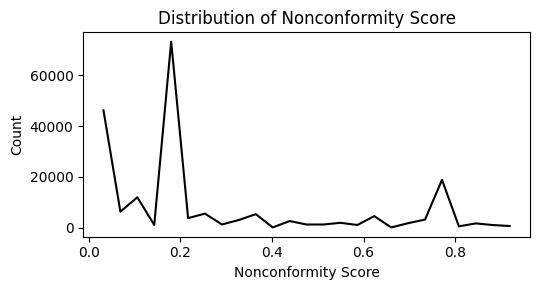

In [166]:
c0, b0 = np.histogram(nc_cal, 25)

plt.rcParams["figure.figsize"] = [5.5,3]
fig, ax = plt.subplots()

ax.plot(b0[:-1], c0, color='black')

plt.ylabel("Count")
plt.xlabel("Nonconformity Score")
plt.title("Distribution of Nonconformity Score")
fig.tight_layout()

plt.show()

In [167]:
nc_test_true = []
nc_test_false = []
for i in range(n_test):
    nc_test_true.append(nonconformity_score(pred_test[i], data['y_test'][i]))
    nc_test_false.append(nonconformity_score(pred_test[i], 1-data['y_test'][i]))

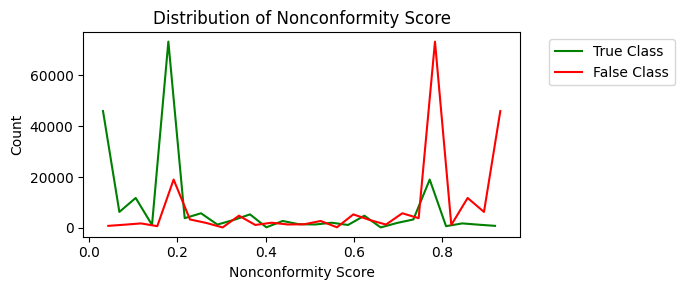

In [168]:
c1, b1 = np.histogram(nc_test_true, 25)
c2, b2 = np.histogram(nc_test_false, 25)

plt.rcParams["figure.figsize"] = [7,3]
fig, ax = plt.subplots()

ax.plot(b1[:-1], c1, color='green', label="True Class")
ax.plot(b2[:-1], c2, color='red', label="False Class")

plt.ylabel("Count")
plt.xlabel("Nonconformity Score")
plt.title("Distribution of Nonconformity Score")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
fig.tight_layout()

plt.show()

### Plot PValues
- Higher P-Value =>
- Higher Probability of Observing More Extreme Nonconformity => 
- Higher Confidence in Predicted Class

In [169]:
pval_test_true = []
pval_test_false = []
for i in range(n_test):
    pval_test_true.append(pvalue(nonconformity_score(pred_test[i], data['y_test'][i])))
    pval_test_false.append(pvalue(nonconformity_score(pred_test[i], 1-data['y_test'][i])))

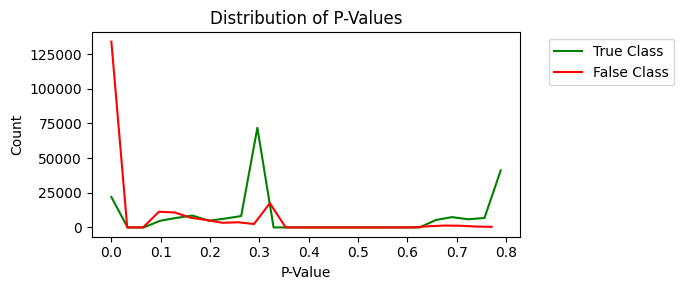

In [170]:
c1, b1 = np.histogram(pval_test_true, 25)
c2, b2 = np.histogram(pval_test_false, 25)

plt.rcParams["figure.figsize"] = [7,3]
fig, ax = plt.subplots()

ax.plot(b1[:-1], c1, color='green', label="True Class")
ax.plot(b2[:-1], c2, color='red', label="False Class")

plt.ylabel("Count")
plt.xlabel("P-Value")
plt.title("Distribution of P-Values")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
fig.tight_layout()

plt.show()

In [171]:
pval_test_true = np.array(pval_test_true)
pval_test_false = np.array(pval_test_false)

for t in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]:
    
    print(t,
          "\t",
          np.sum(pval_test_true>=t)/n_test, 
          np.sum(pval_test_false>=t)/n_test,
          "\t",
          np.sum((pval_test_true>=t)&(pval_test_false>=t))/n_test,
          np.sum((pval_test_true<t)&(pval_test_false<t))/n_test)

0.05 	 0.89031 0.33003 	 0.22034 0.0
0.1 	 0.89031 0.33003 	 0.22034 0.0
0.15 	 0.84529 0.2382 	 0.08349 0.0
0.2 	 0.78939 0.174335 	 0.0 0.036275
0.25 	 0.746405 0.14421 	 0.0 0.109385
0.3 	 0.69236 0.11711 	 0.0 0.19053
0.4 	 0.333045 0.02239 	 0.0 0.644565
0.5 	 0.333045 0.02239 	 0.0 0.644565


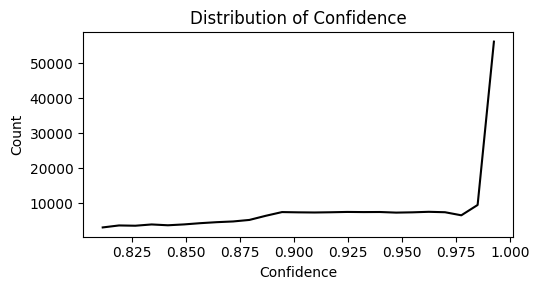

In [172]:
### Plot Confidence (How likely prediction is singleton)

c0, b0 = np.histogram(conf, 25)

plt.rcParams["figure.figsize"] = [5.5,3]
fig, ax = plt.subplots()

ax.plot(b0[:-1], c0, color='black')

plt.ylabel("Count")
plt.xlabel("Confidence")
plt.title("Distribution of Confidence")
fig.tight_layout()

plt.show()

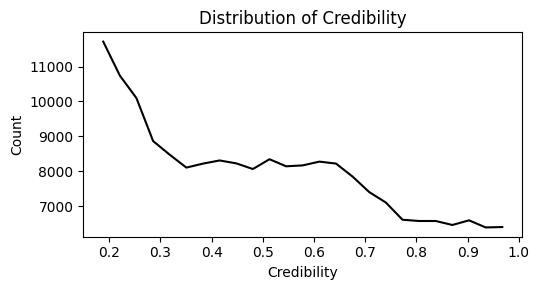

In [173]:
### Plot Credibility (How likely sample is from training set)

c0, b0 = np.histogram(cred, 25)

plt.rcParams["figure.figsize"] = [5.5,3]
fig, ax = plt.subplots()

ax.plot(b0[:-1], c0, color='black')

plt.ylabel("Count")
plt.xlabel("Credibility")
plt.title("Distribution of Credibility")
fig.tight_layout()

plt.show()